# Modeling Credit Risk with Lending Club data

### Outline

1. Business problem and summary of results
2. Data import.
3. Data preprocessing.
4. EDA.
5. Sample split, missing values and feature engineering.
6. Modeling.
7. Interpretation of the results.
8. Business implications.

#### Objective: Predict delinquency of a borrower
#### Metric: ROCAUC or PRAUC


The biggest question re this data is which features are pulled at origination time.
For the details on this, see stuff below:
- https://www.kaggle.com/datasets/wordsforthewise/lending-club/discussion/220358
- https://www.kaggle.com/code/tysonpo/columns-available-at-origination-answer/notebook

From those links above, it seems that most features are pulled at loan application/origination. 
The only features, pulled later, belong to the two groups:
- features, related to loan performance/payments.
- features, which clearly mention this in name/description. E.g., word 'last' in feature name.

Notes:
Address is a key feature. Try to get it. Zip_code from address wil dramatically improve results.
And use ohe for more cat features.

### Business Problem

### Objective

### Summary of Results

## 2. Data import

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys, re
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [7]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [8]:
time0 = time.time()

with open('../input/lc-sample850k/LCLoans_sample850k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
    
display(df.head())

features_tokeep = ['id', 'loan_status',
 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment','issue_d',
 'purpose', 'title', 'initial_list_status', 'application_type',
 'grade', 'sub_grade', 'fico_range_high',
 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'zip_code', 'addr_state',
 'dti',           
 'verification_status', 
 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record',
 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
 'num_tl_op_past_12m', 
 'earliest_cr_line', 'inq_last_6mths', 'inq_fi', 'inq_last_12m',
 'open_acc', 'acc_open_past_24mths', 'mort_acc', 'total_acc',
 'avg_cur_bal', 'il_util', 'tot_cur_bal', 
 'revol_bal', 'revol_util', 'max_bal_bc', 'bc_open_to_buy', 'mo_sin_rcnt_rev_tl_op', 'num_actv_rev_tl', 'num_op_rev_tl', 'total_rev_hi_lim',               
 'delinq_2yrs', 'acc_now_delinq', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies',
 'annual_inc_joint', 'dti_joint', 'verification_status_joint',
 'total_bal_ex_mort', 'tot_coll_amt', 'tax_liens', 'percent_bc_gt_75', 'pct_tl_nvr_dlq', 
 'open_rv_12m', 'open_il_12m', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m',
 'num_accts_ever_120_pd',
 'recoveries']

df = df[features_tokeep]

recoveries = df[['id', 'recoveries', 'loan_amnt', 'int_rate']]

df.drop(columns = ['recoveries'], inplace=True)
df.drop(columns = ['il_util', 'max_bal_bc'], inplace=True)
# these are useful features, which I will preprocess later

df.issue_d = df.issue_d.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
#df = df[df.year_issued.isin([2018])]
    
df = df.sample(200000)
df.reset_index(inplace=True, drop=True)
display(df.shape, time.time()-time0, df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
2,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3005.666748,3005.669922,2400.000000,605.669983,0.0,0.000000,0.00,Jun-2014,649.909973,NaN,Jun-2017,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,675.0,679.0,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,647.500000,647.500000,162.020004,294.940002,0.0,190.539993,2.09,Apr-2012,152.389999,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
11,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,B,B5,UCLA,10+ years,OWN,75000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Consolidation,913xx,CA,1

(200000, 68)

2.267568826675415

,id,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued
0,6329942,Fully Paid,25000.0,25000.0,25000.0,60.0,21.15,678.450012,2013-08-01,debt_consolidation,Debt Consolidation Loan,f,Individual,E,E2,709.0,Bristol-Myers Squibb,10+ years,MORTGAGE,96000.0,130xx,NY,24.450001,Verified,6.0,62.0,NaN,NaN,62.0,62.0,4.0,Dec-1991,0.0,NaN,NaN,16.0,9.0,5.0,56.0,13113.0,196699.0,10345.0,46.8,3163.0,6.0,5.0,10.0,22100.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,75043.0,0.0,0.0,75.000000,98.000000,NaN,NaN,0.0,0.0,0.0,0.0,2013.0
1,26730242,Fully Paid,16000.0,16000.0,16000.0,36.0,16.29,564.809998,2014-10-01,debt_consolidation,Debt consolidation,f,Individual,D,D2,674.0,meat manager,10+ years,MORTGAGE,63000.0,212xx,MD,24.990000,Verified,3.0,16.0,43.0,NaN,NaN,NaN,8.0,Aug-2000,1.0,NaN,NaN,16.0,9.0,1.0,36.0,11446.0,183142.0,11314.0,64.7,3852.0,3.0,8.0,12.0,17500.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,46506.0,0.0,0.0,63.599998,91.699997,NaN,NaN,0.0,0.0,0.0,1.0,2014.0
2,3254588,Fully Paid,11000.0,11000.0,11000.0,36.0,12.12,365.989990,2013-02-01,credit_card,Credit Card Payoff,f,Individual,B,B3,694.0,Franklin County DSS,10+ years,RENT,65000.0,129xx,NY,8.340000,Verified,1.0,64.0,67.0,NaN,64.0,64.0,2.0,Sep-1983,0.0,NaN,NaN,10.0,2.0,2.0,33.0,1974.0,13819.0,10819.0,36.2,11660.0,6.0,3.0,9.0,29900.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,13819.0,0.0,0.0,0.000000,87.000000,NaN,NaN,0.0,0.0,0.0,2.0,2013.0
3,50495980,Fully Paid,6000.0,6000.0,6000.0,36.0,16.99,213.889999,2015-06-01,other,Other,w,Individual,D,D3,669.0,Junior Buyer,1 year,MORTGAGE,49179.0,281xx,NC,33.090000,Source Verified,1.0,27.0,27.0,65.0,NaN,NaN,3.0,Jul-2003,0.0,NaN,NaN,9.0,4.0,1.0,14.0,27522.0,247699.0,11818.0,88.9,119.0,1.0,5.0,5.0,13300.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,99854.0,0.0,0.0,100.000000,85.699997,NaN,NaN,0.0,0.0,0.0,2.0,2015.0
4,135764207,Fully Paid,16000.0,16000.0,16000.0,36.0,5.31,481.769989,2018-06-01,debt_consolidation,Debt consolidation,w,Individual,A,A1,764.0,Mortgage underwriter,10+ years,OWN,90000.0,337xx,FL,5.880000,Not Verified,26.0,NaN,NaN,NaN,NaN,NaN,0.0,Aug-1992,0.0,0.0,0.0,11.0,0.0,2.0,25.0,15470.0,154703.0,19549.0,30.5,31219.0,26.0,7.0,10.0,64000.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,19549.0,0.0,0.0,16.700001,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0


## 3. Data preprocessing

In [9]:
### feature description:

#f_desc = pd.read_excel('../input/lending-club-20072020q1/LCDataDictionary.xlsx')
#f_desc.columns = ['colname','desc']
#display(f_desc.head())
#display(f_desc)
#display(f_desc.loc[f_desc.colname=='open_acc','desc'], f_desc.loc[f_desc.colname=='total_acc','desc'])

In [10]:
# remove some very rarae loan types:

df = df[~df.purpose.isin(['educational', 'renewable_energy', 'wedding'])]
df.purpose = df.purpose.cat.remove_categories(['educational', 'renewable_energy', 'wedding'])


In [11]:
# clean time features

df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['month_issued']=df.issue_d.dt.month
df['year_earliest']=df.issue_d.dt.year
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
df['pub_rec_pa'] = df.pub_rec/df.years_borrowing
display(df.head())

,id,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa
0,6329942,Fully Paid,25000.0,25000.0,25000.0,60.0,21.15,678.450012,2013-08-01,debt_consolidation,Debt Consolidation Loan,f,Individual,E,E2,709.0,Bristol-Myers Squibb,10+ years,MORTGAGE,96000.0,130xx,NY,24.450001,Verified,6.0,62.0,NaN,NaN,62.0,62.0,4.0,1991-12-01,0.0,NaN,NaN,16.0,9.0,5.0,56.0,13113.0,196699.0,10345.0,46.8,3163.0,6.0,5.0,10.0,22100.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,75043.0,0.0,0.0,75.000000,98.000000,NaN,NaN,0.0,0.0,0.0,0.0,2013.0,8.0,2013.0,21.667796,0.000000
1,26730242,Fully Paid,16000.0,16000.0,16000.0,36.0,16.29,564.809998,2014-10-01,debt_consolidation,Debt consolidation,f,Individual,D,D2,674.0,meat manager,10+ years,MORTGAGE,63000.0,212xx,MD,24.990000,Verified,3.0,16.0,43.0,NaN,NaN,NaN,8.0,2000-08-01,1.0,NaN,NaN,16.0,9.0,1.0,36.0,11446.0,183142.0,11314.0,64.7,3852.0,3.0,8.0,12.0,17500.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,46506.0,0.0,0.0,63.599998,91.699997,NaN,NaN,0.0,0.0,0.0,1.0,2014.0,10.0,2014.0,14.165931,0.000000
2,3254588,Fully Paid,11000.0,11000.0,11000.0,36.0,12.12,365.989990,2013-02-01,credit_card,Credit Card Payoff,f,Individual,B,B3,694.0,Franklin County DSS,10+ years,RENT,65000.0,129xx,NY,8.340000,Verified,1.0,64.0,67.0,NaN,64.0,64.0,2.0,1983-09-01,0.0,NaN,NaN,10.0,2.0,2.0,33.0,1974.0,13819.0,10819.0,36.2,11660.0,6.0,3.0,9.0,29900.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,13819.0,0.0,0.0,0.000000,87.000000,NaN,NaN,0.0,0.0,0.0,2.0,2013.0,2.0,2013.0,29.421549,0.000000
3,50495980,Fully Paid,6000.0,6000.0,6000.0,36.0,16.99,213.889999,2015-06-01,other,Other,w,Individual,D,D3,669.0,Junior Buyer,1 year,MORTGAGE,49179.0,281xx,NC,33.090000,Source Verified,1.0,27.0,27.0,65.0,NaN,NaN,3.0,2003-07-01,0.0,NaN,NaN,9.0,4.0,1.0,14.0,27522.0,247699.0,11818.0,88.9,119.0,1.0,5.0,5.0,13300.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,99854.0,0.0,0.0,100.000000,85.699997,NaN,NaN,0.0,0.0,0.0,2.0,2015.0,6.0,2015.0,11.918109,0.083906
4,135764207,Fully Paid,16000.0,16000.0,16000.0,36.0,5.31,481.769989,2018-06-01,debt_consolidation,Debt consolidation,w,Individual,A,A1,764.0,Mortgage underwriter,10+ years,OWN,90000.0,337xx,FL,5.880000,Not Verified,26.0,NaN,NaN,NaN,NaN,NaN,0.0,1992-08-01,0.0,0.0,0.0,11.0,0.0,2.0,25.0,15470.0,154703.0,19549.0,30.5,31219.0,26.0,7.0,10.0,64000.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,19549.0,0.0,0.0,16.700001,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,6.0,2018.0,25.832153,0.000000


In [12]:
# creating a target variable

display(df.loan_status.value_counts())
df.target=np.nan
#df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
#df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df.loc[df.loan_status.isin(['Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             98778
Current                                                72833
Charged Off                                            25630
Late (31-120 days)                                      1153
In Grace Period                                          703
Late (16-30 days)                                        215
Issued                                                   146
Does not meet the credit policy. Status:Fully Paid       129
Does not meet the credit policy. Status:Charged Off       51
Default                                                   37
Name: loan_status, dtype: int64

(124445, 73)

Fully Paid                                             98778
Charged Off                                            25630
Default                                                   37
Current                                                    0
Does not meet the credit policy. Status:Charged Off        0
Does not meet the credit policy. Status:Fully Paid         0
In Grace Period                                            0
Issued                                                     0
Late (16-30 days)                                          0
Late (31-120 days)                                         0
Name: loan_status, dtype: int64

id                                124445
loan_status                       124445
loan_amnt                         124445
funded_amnt                       124445
funded_amnt_inv                   124445
term                              124445
int_rate                          124445
installment                       124445
issue_d                           124445
purpose                           124445
title                             122958
initial_list_status               124445
application_type                  124445
grade                             124445
sub_grade                         124445
fico_range_high                   124445
emp_title                         115885
emp_length                        116803
home_ownership                    124445
annual_inc                        124445
zip_code                          124445
addr_state                        124445
dti                               124374
verification_status               124445
mo_sin_rcnt_tl  

85.88511180877686

### 3. Feature Preprocessing

In [13]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>1.5, 'lti']=1.5
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=1
df.loc[df.revol_util>100,'revol_util']=100
df.loc[df.dti>100, 'dti']=100
df.loc[df.dti<0, 'dti']=0

# add more features

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.amnt_same = (df.loan_amnt == df.funded_amnt_inv).astype(int)
df['revol_balance_income'] = df.revol_bal/df.annual_inc
df['avg_cur_bal_inc'] = df.avg_cur_bal/df.annual_inc
df['tot_cur_bal_inc'] = df.tot_cur_bal/df.annual_inc
df['total_bal_ex_mort_inc'] = df.total_bal_ex_mort/df.annual_inc
df['total_rev_inc'] = df.total_rev_hi_lim/df.annual_inc

df['low_fico'] = (df.fico_range_high<=659).astype(int)
df['open_cl_ratio']=df.open_acc/df.total_acc
df.loc[df.home_ownership.isin(['ANY','NONE','OTHER']), 'home_ownership'] = 'OTHER'
df['was_bankrupt'] = (df.pub_rec_bankruptcies>0).astype(int)

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

df.head()

10.0    41180
2.0     11225
0.0     10255
3.0      9972
1.0      8144
5.0      7731
4.0      7531
6.0      5733
8.0      5325
7.0      5233
9.0      4474
Name: emp_length, dtype: int64

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,6329942,25000.0,25000.0,25000.0,60.0,21.15,678.450012,debt_consolidation,Debt Consolidation Loan,f,Individual,E,E2,709.0,Bristol-Myers Squibb,10.0,MORTGAGE,96000.0,130,NY,24.450001,Verified,6.0,62.0,NaN,NaN,62.0,62.0,4.0,0.0,NaN,NaN,16.0,9.0,5.0,56.0,13113.0,196699.0,10345.0,46.8,3163.0,6.0,5.0,10.0,22100.0,0.0,0.0,0.0,0.0,0.0,75043.0,0.0,0.0,75.000000,98.000000,NaN,NaN,0.0,0.0,0.0,0.0,2013.0,8.0,2013.0,21.667796,0.000000,0.0,0.260417,0.084806,0,0.107760,0.136594,2.048948,0.781698,0.230208,0,0.285714,0
1,26730242,16000.0,16000.0,16000.0,36.0,16.29,564.809998,debt_consolidation,Debt consolidation,f,Individual,D,D2,674.0,meat manager,10.0,MORTGAGE,63000.0,212,MD,24.990000,Verified,3.0,16.0,43.0,NaN,NaN,NaN,8.0,1.0,NaN,NaN,16.0,9.0,1.0,36.0,11446.0,183142.0,11314.0,64.7,3852.0,3.0,8.0,12.0,17500.0,1.0,0.0,0.0,0.0,0.0,46506.0,0.0,0.0,63.599998,91.699997,NaN,NaN,0.0,0.0,0.0,1.0,2014.0,10.0,2014.0,14.165931,0.000000,0.0,0.253968,0.107583,0,0.179587,0.181683,2.907016,0.738190,0.277778,0,0.444444,0
2,3254588,11000.0,11000.0,11000.0,36.0,12.12,365.989990,credit_card,Credit Card Payoff,f,Individual,B,B3,694.0,Franklin County DSS,10.0,RENT,65000.0,129,NY,8.340000,Verified,1.0,64.0,67.0,NaN,64.0,64.0,2.0,0.0,NaN,NaN,10.0,2.0,2.0,33.0,1974.0,13819.0,10819.0,36.2,11660.0,6.0,3.0,9.0,29900.0,0.0,0.0,0.0,0.0,0.0,13819.0,0.0,0.0,0.000000,87.000000,NaN,NaN,0.0,0.0,0.0,2.0,2013.0,2.0,2013.0,29.421549,0.000000,0.0,0.169231,0.067567,0,0.166446,0.030369,0.212600,0.212600,0.460000,0,0.303030,0
3,50495980,6000.0,6000.0,6000.0,36.0,16.99,213.889999,other,Other,w,Individual,D,D3,669.0,Junior Buyer,1.0,MORTGAGE,49179.0,281,NC,33.090000,Source Verified,1.0,27.0,27.0,65.0,NaN,NaN,3.0,0.0,NaN,NaN,9.0,4.0,1.0,14.0,27522.0,247699.0,11818.0,88.9,119.0,1.0,5.0,5.0,13300.0,0.0,0.0,0.0,1.0,0.0,99854.0,0.0,0.0,100.000000,85.699997,NaN,NaN,0.0,0.0,0.0,2.0,2015.0,6.0,2015.0,11.918109,0.083906,0.0,0.122003,0.052191,0,0.240306,0.559629,5.036682,2.030420,0.270441,0,0.642857,0
4,135764207,16000.0,16000.0,16000.0,36.0,5.31,481.769989,debt_consolidation,Debt consolidation,w,Individual,A,A1,764.0,Mortgage underwriter,10.0,OWN,90000.0,337,FL,5.880000,Not Verified,26.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,11.0,0.0,2.0,25.0,15470.0,154703.0,19549.0,30.5,31219.0,26.0,7.0,10.0,64000.0,0.0,0.0,0.0,0.0,0.0,19549.0,0.0,0.0,16.700001,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,6.0,2018.0,25.832153,0.000000,0.0,0.177778,0.064236,0,0.217211,0.171889,1.718922,0.217211,0.711111,0,0.440000,0


In [14]:
# For features like 'time_since some credit event', treat NA as never and fill those values with 100 years equivalent

df.mo_sin_rcnt_tl = df.mo_sin_rcnt_tl.fillna(value=120)
df.num_tl_op_past_12m = df.num_tl_op_past_12m.fillna(value=0)

months_since_col = ['mths_since_last_delinq', 'mths_since_last_major_derog', 
                    'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq']

for col in months_since_col:
    df[col] = df[col].fillna(value=1200)

display(df.count())

df.inq_fi = df.inq_fi.fillna(value=0)
df.inq_last_12m = df.inq_last_12m.fillna(value=0)



id                                124445
loan_amnt                         124445
funded_amnt                       124445
funded_amnt_inv                   124445
term                              124445
int_rate                          124445
installment                       124445
purpose                           124445
title                             122958
initial_list_status               124445
application_type                  124445
grade                             124445
sub_grade                         124445
fico_range_high                   124445
emp_title                         115885
emp_length                        116803
home_ownership                    124445
annual_inc                        124445
zip_code                          124445
addr_state                        124445
dti                               124374
verification_status               124445
mo_sin_rcnt_tl                    124445
mths_since_last_delinq            124445
mths_since_last_

In [15]:
df.mo_sin_rcnt_tl.describe()

count    124445.000000
mean         12.203447
std          22.800325
min           0.000000
25%           3.000000
50%           6.000000
75%          11.000000
max         272.000000
Name: mo_sin_rcnt_tl, dtype: float64

In [16]:
df.target.mean()

0.20625175780465266

In [17]:
cat_features_te = ['sub_grade', 'emp_title', 'purpose', 'title', 'zip_code', 'addr_state', 'grade', 'home_ownership']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

In [18]:
df.application_type.value_counts()

Individual    119984
Joint App       4461
Name: application_type, dtype: int64

### 4. EDA

In [19]:
print('Bankruptcy incidnce is the sample is: ', df.target.mean())

Bankruptcy incidnce is the sample is:  0.20625175780465266


In [20]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,124445.000000,124445.000000,124445.000000
mean,14423.744141,14417.614258,14400.276367
std,8937.675781,8934.314453,8935.287109
min,750.000000,750.000000,0.000000
25%,7500.000000,7500.000000,7500.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36.0    95441
60.0    29004
Name: term, dtype: int64

So the three amount features above are basically identical.

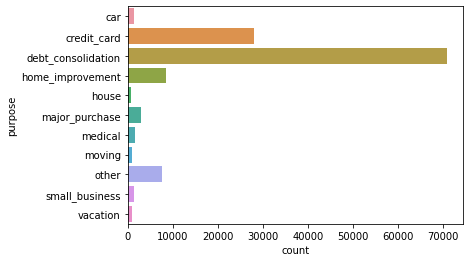

<AxesSubplot:xlabel='count', ylabel='emp_length'>

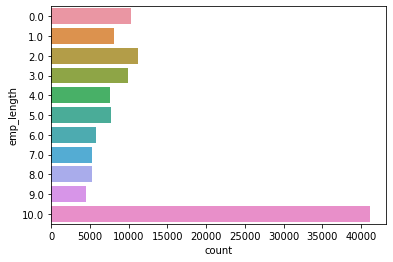

In [21]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [22]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

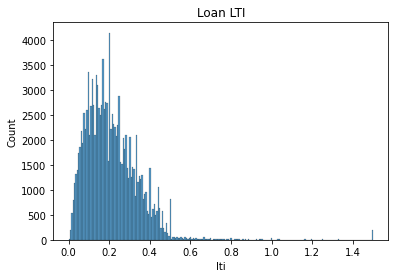

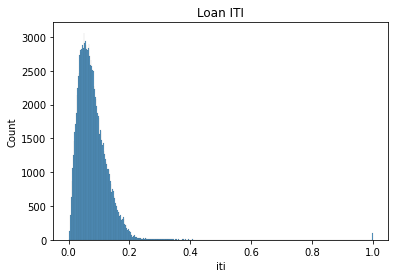

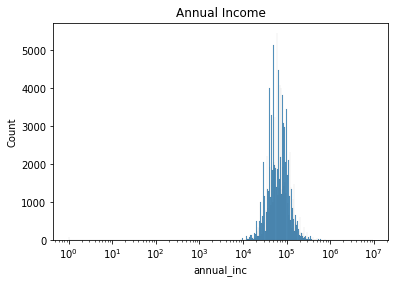

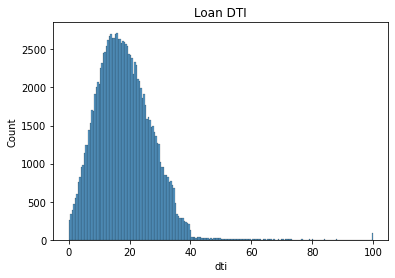

In [23]:
#sns.histplot(x='int_rate', data=df).set(title='Loan LTI')
#plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()
sns.histplot(x='dti', data=df).set(title='Loan DTI')
plt.show()

In [24]:
df.dti.describe()

count    124374.000000
mean         18.290451
std           9.221872
min           0.000000
25%          11.750000
50%          17.540001
75%          24.000000
max         100.000000
Name: dti, dtype: float64

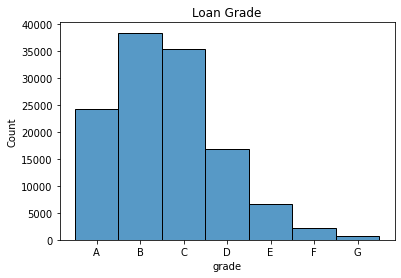

In [25]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')
plt.show()

### EDA with target

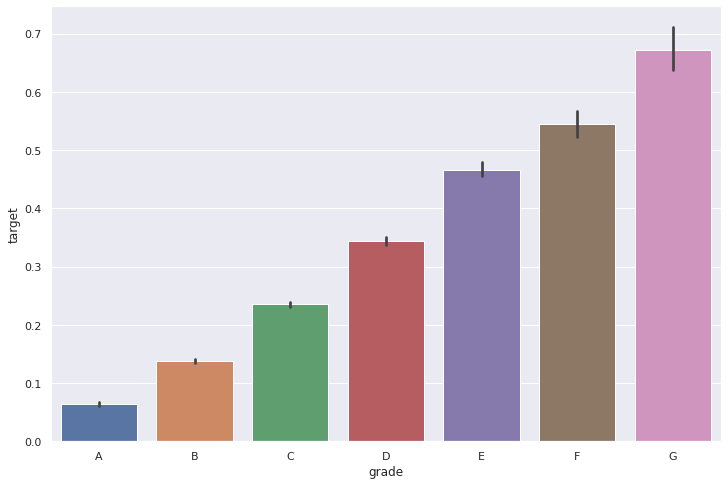

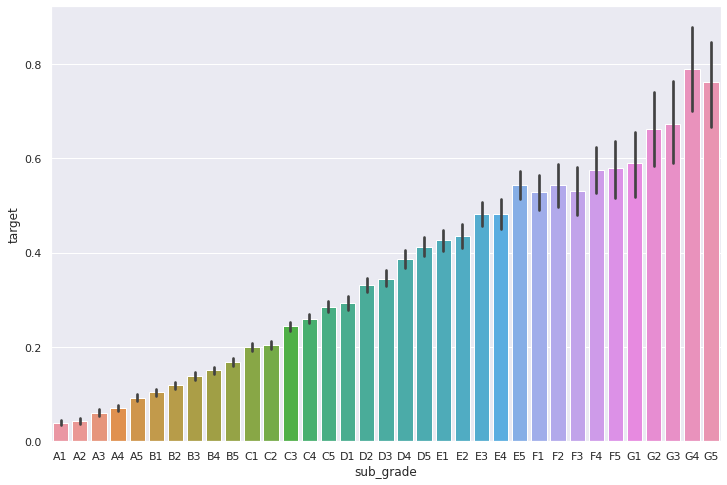

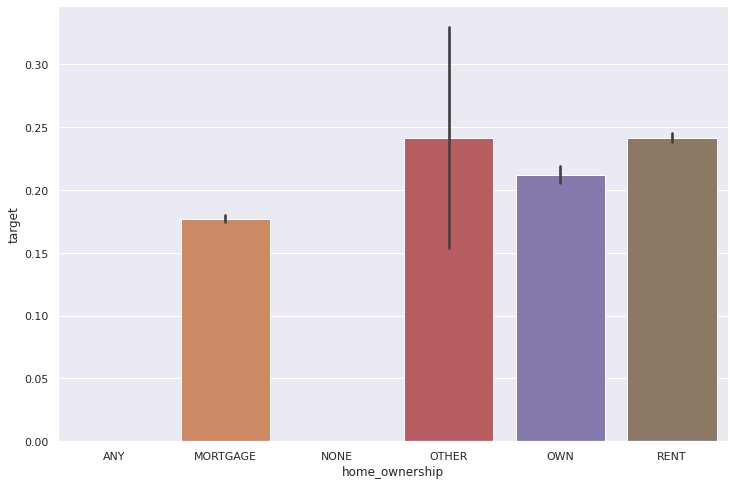

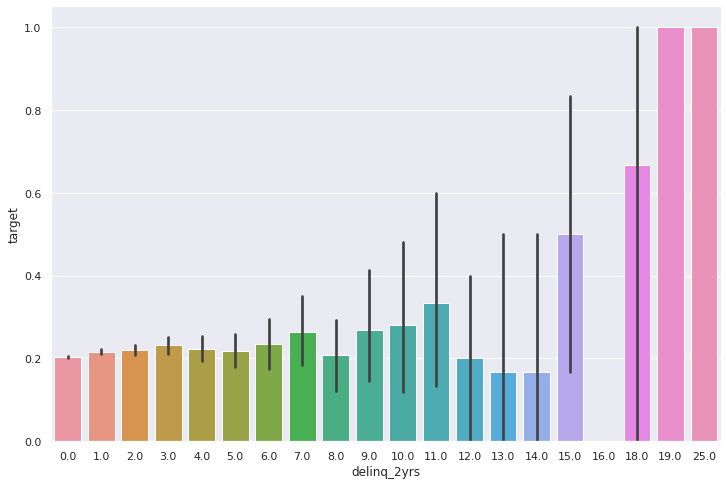

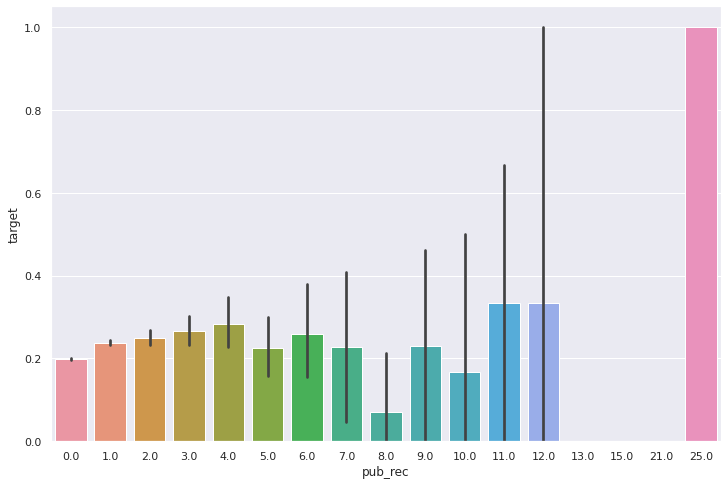

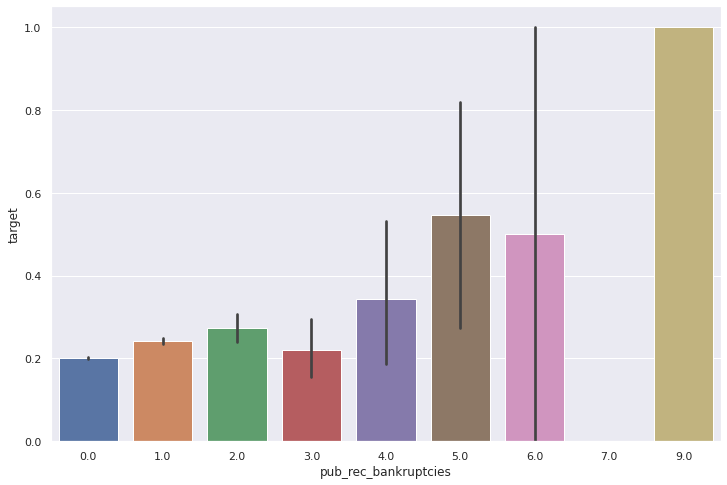

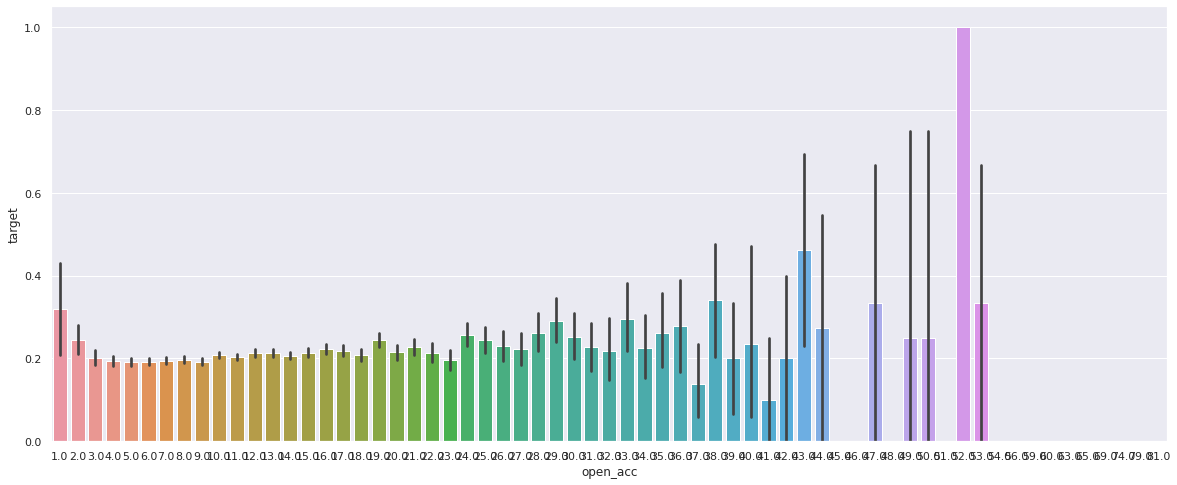

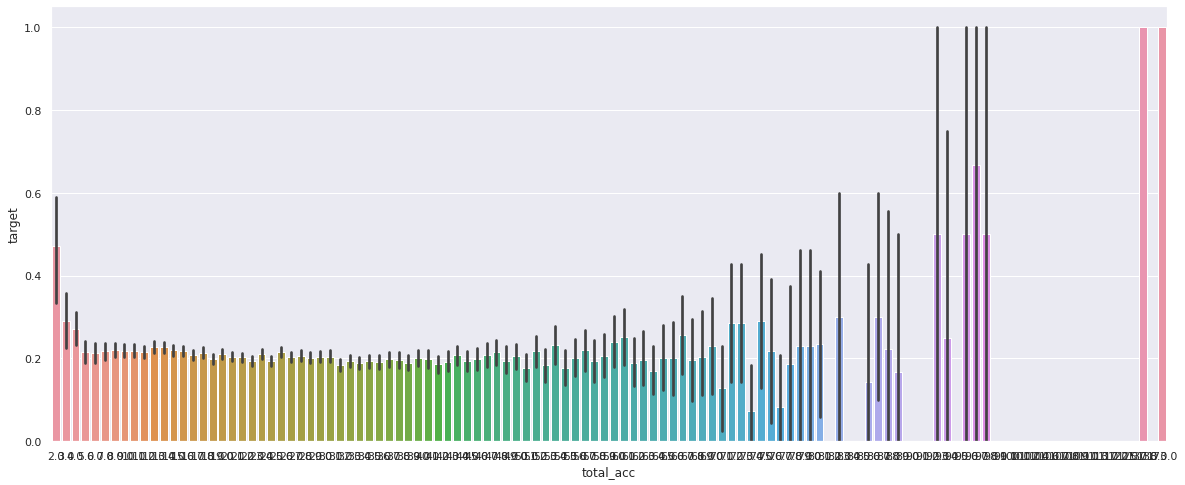

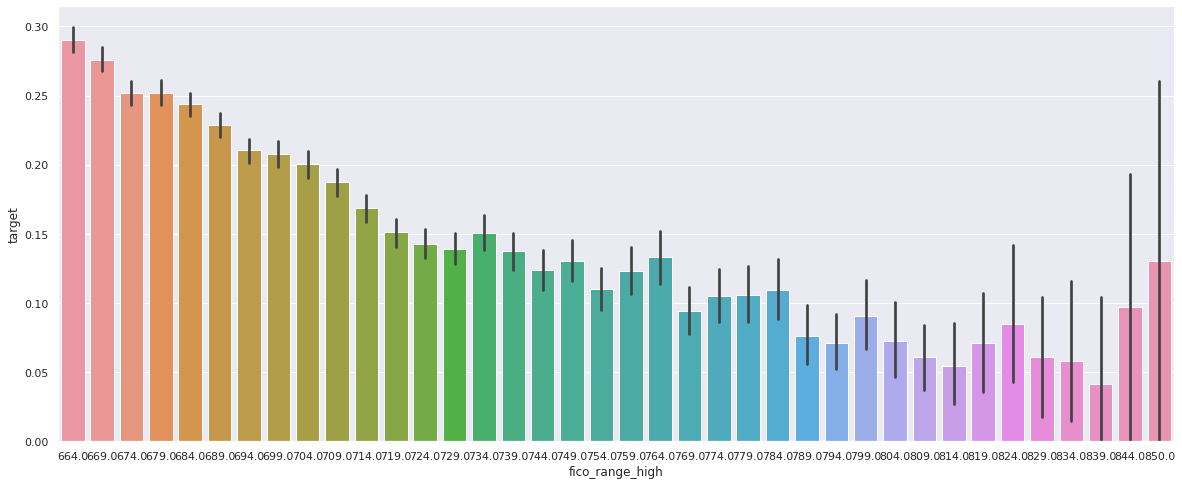

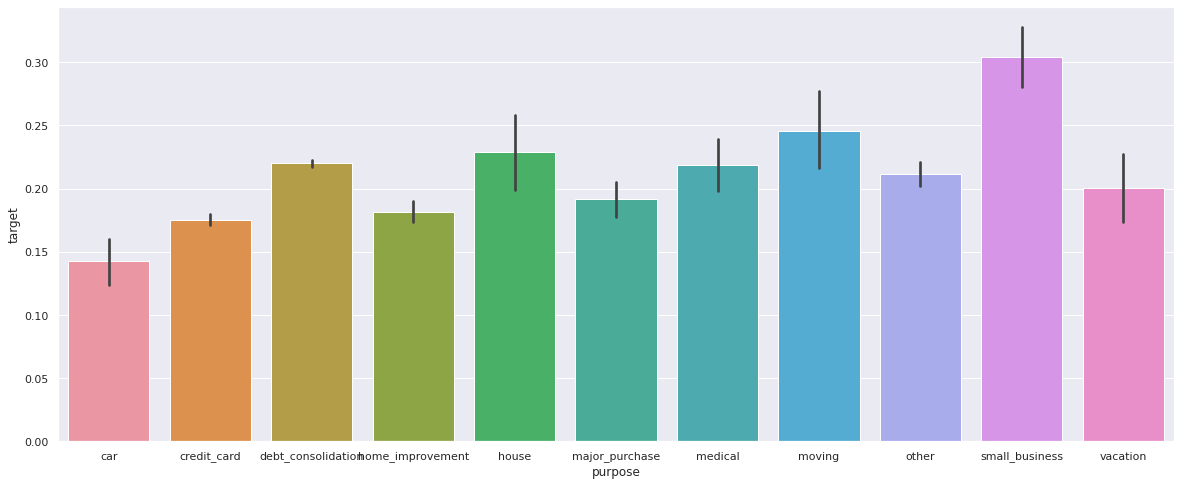

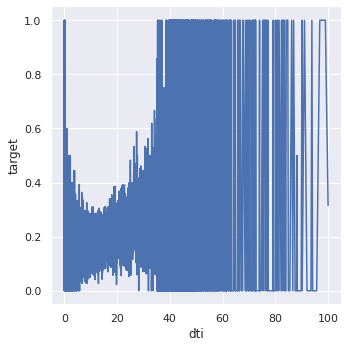

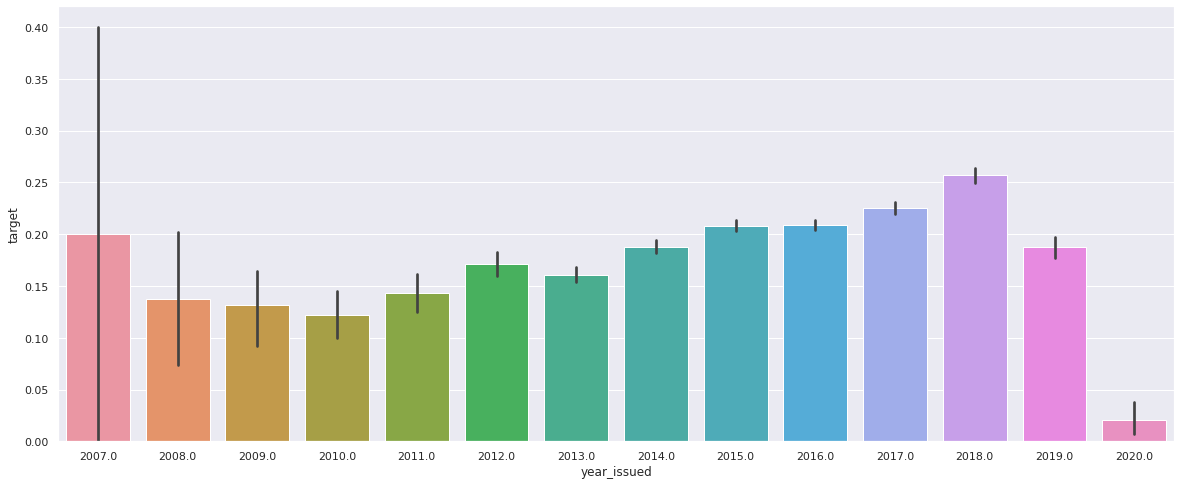

In [26]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='home_ownership', y='target', data=df)
plt.show()
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec_bankruptcies', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(x='open_acc', y='target', data=df)
plt.show()
sns.barplot(x='total_acc', y='target', data=df)
plt.show()
sns.barplot(x='fico_range_high', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()
sns.relplot(x='dti', y='target', data=df, ci=None, kind = 'line')
plt.show()
sns.barplot(x='year_issued', y='target', data=df)
plt.show()

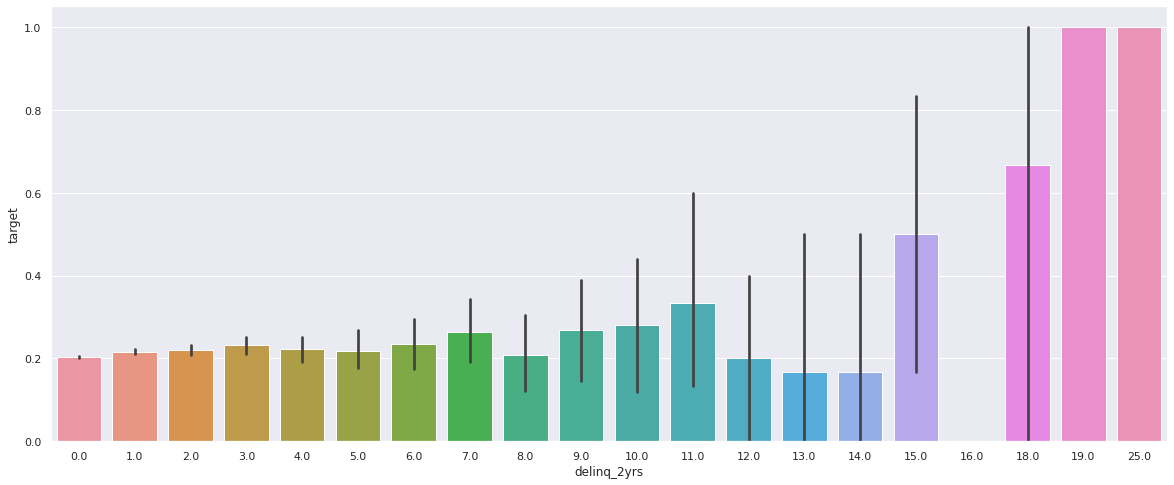

In [27]:
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()

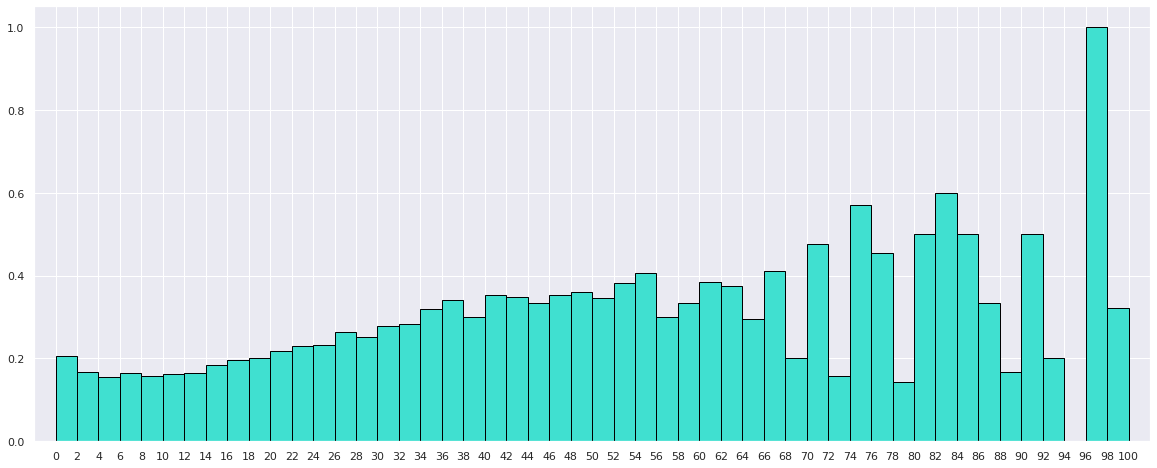

In [28]:
a = df.dti
b = df.target
bins = np.linspace(a.min(), a.max() + 1e-12, 51) # 10 bins, so 11 bin boundaries
c = np.digitize(a, bins)
plt.bar(bins[:-1], [np.mean(b[c == i]) for i in range(1, len(bins))],
        width=bins[1] - bins[0], align='edge', fc='turquoise', ec='black')
plt.xticks(bins)
plt.margins(x=0.02) # smaller margins
plt.show()

### 5. Train-test split, missing values and feature engineering

In [29]:
display(df.count())

id                                124445
loan_amnt                         124445
funded_amnt                       124445
funded_amnt_inv                   124445
term                              124445
int_rate                          124445
installment                       124445
purpose                           124445
title                             122958
initial_list_status               124445
application_type                  124445
grade                             124445
sub_grade                         124445
fico_range_high                   124445
emp_title                         115885
emp_length                        116803
home_ownership                    124445
annual_inc                        124445
zip_code                          124445
addr_state                        124445
dti                               124374
verification_status               124445
mo_sin_rcnt_tl                    124445
mths_since_last_delinq            124445
mths_since_last_

In [30]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']
features_fill_zero = ['open_rv_12m', 'open_il_12m', 'emp_length', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m']

for col in features_fill_zero:
    df[col] = df[col].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')

test_size = 0.25
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
test00 = test.copy()
train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

display(train.count())

(93334, 77)

(31111, 77)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,25000.0,25000.0,25000.0,60.0,21.15,678.450012,debt_consolidation,Debt Consolidation Loan,f,Individual,E,E2,709.0,Bristol-Myers Squibb,10.0,MORTGAGE,96000.0,130,NY,24.450001,Verified,6.0,62.0,1200.0,1200.0,62.0,62.0,4.0,0.0,0.0,0.0,16.0,9.0,5.0,56.0,13113.0,196699.0,10345.0,46.8,3163.0,6.0,5.0,10.0,22100.0,0.0,0.0,0.0,0.0,0.0,75043.0,0.0,0.0,75.0,98.000000,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,8.0,2013.0,21.667796,0.000000,0.0,0.260417,0.084806,0,0.107760,0.136594,2.048948,0.781698,0.230208,0,0.285714,0
1,11000.0,11000.0,11000.0,36.0,12.12,365.989990,credit_card,Credit Card Payoff,f,Individual,B,B3,694.0,Franklin County DSS,10.0,RENT,65000.0,129,NY,8.340000,Verified,1.0,64.0,67.0,1200.0,64.0,64.0,2.0,0.0,0.0,0.0,10.0,2.0,2.0,33.0,1974.0,13819.0,10819.0,36.2,11660.0,6.0,3.0,9.0,29900.0,0.0,0.0,0.0,0.0,0.0,13819.0,0.0,0.0,0.0,87.000000,0.0,0.0,0.0,0.0,0.0,2.0,2013.0,2.0,2013.0,29.421549,0.000000,0.0,0.169231,0.067567,0,0.166446,0.030369,0.212600,0.212600,0.460000,0,0.303030,0
2,6000.0,6000.0,6000.0,36.0,16.99,213.889999,other,Other,w,Individual,D,D3,669.0,Junior Buyer,1.0,MORTGAGE,49179.0,281,NC,33.090000,Source Verified,1.0,27.0,27.0,65.0,1200.0,1200.0,3.0,0.0,0.0,0.0,9.0,4.0,1.0,14.0,27522.0,247699.0,11818.0,88.9,119.0,1.0,5.0,5.0,13300.0,0.0,0.0,0.0,1.0,0.0,99854.0,0.0,0.0,100.0,85.699997,0.0,0.0,0.0,0.0,0.0,2.0,2015.0,6.0,2015.0,11.918109,0.083906,0.0,0.122003,0.052191,0,0.240306,0.559629,5.036682,2.030420,0.270441,0,0.642857,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,4000.0,4000.0,4000.0,36.0,10.75,130.490005,debt_consolidation,MISSING,w,Individual,B,B4,674.0,Caregiver,2.0,MORTGAGE,27040.0,330,FL,15.53,Not Verified,5.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,1.0,5.0,1.0,0.0,5.0,1469.0,7347.0,7347.0,87.0,2550.0,5.0,5.0,5.0,8400.0,0.0,0.0,0.0,0.0,0.0,7347.0,0.0,0.0,100.000000,100.000000,1.0,0.0,0.0,0.0,0.0,0.0,2016.0,6.0,2016.0,8.668214,0.000000,1.0,0.147929,0.057910,0,0.271709,0.054327,0.271709,0.271709,0.310651,0,1.000000,0
1,20000.0,20000.0,20000.0,36.0,6.92,616.820007,credit_card,Credit card refinancing,w,Individual,A,A4,704.0,Regulatory Manager,7.0,MORTGAGE,65000.0,800,CO,12.92,Source Verified,21.0,33.0,33.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,12.0,3.0,5.0,24.0,29015.0,261132.0,11756.0,59.4,5444.0,21.0,2.0,9.0,19800.0,0.0,0.0,0.0,0.0,0.0,21972.0,0.0,0.0,33.299999,95.800003,0.0,0.0,0.0,0.0,0.0,1.0,2015.0,4.0,2015.0,27.083376,0.000000,0.0,0.307692,0.113874,0,0.180862,0.446385,4.017416,0.338031,0.304615,0,0.500000,0
2,8400.0,8400.0,8400.0,36.0,13.35,284.450012,medical,Medical expenses,f,Individual,C,C2,664.0,Finance Manager,2.0,MORTGAGE,180000.0,370,TN,11.93,Source Verified,1.0,47.0,47.0,39.0,47.0,47.0,3.0,1.0,0.0,0.0,5.0,4.0,1.0,15.0,77184.0,385919.0,1094.0,16.8,5406.0,12.0,1.0,1.0,6500.0,0.0,0.0,0.0,3.0,0.0,84439.0,977.0,0.0,0.000000,85.699997,0.0,0.0,0.0,0.0,0.0,1.0,2014.0,5.0,2014.0,18.664312,0.160735,1.0,0.046667,0.018963,0,0.006078,0.428800,2.143994,0.469106,0.036111,0,0.333333,0


loan_amnt                         93334
funded_amnt                       93334
funded_amnt_inv                   93334
term                              93334
int_rate                          93334
installment                       93334
purpose                           93334
title                             93334
initial_list_status               93334
application_type                  93334
grade                             93334
sub_grade                         93334
fico_range_high                   93334
emp_title                         93334
emp_length                        93334
home_ownership                    93334
annual_inc                        93334
zip_code                          93334
addr_state                        93334
dti                               93334
verification_status               93334
mo_sin_rcnt_tl                    93334
mths_since_last_delinq            93334
mths_since_last_major_derog       93334
mths_since_last_record            93334


### Categorical features encoding

In [31]:
# TE for categorical features

time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

freq_enc = (train.groupby('title').size()) / len(train)
train['title_fencoded'] = train['title'].apply(lambda x : freq_enc[x])
test['title_fencoded'] = test['title'].apply(lambda x : freq_enc[x])

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

56.28270506858826

3.5194225311279297

(93334, 78)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,25000.0,25000.0,25000.0,60.0,21.15,678.450012,f,Individual,709.0,10.0,96000.0,24.450001,Verified,6.0,62.0,1200.0,1200.0,62.0,62.0,4.0,0.0,0.0,0.0,16.0,9.0,5.0,56.0,13113.0,196699.0,10345.0,46.8,3163.0,6.0,5.0,10.0,22100.0,0.0,0.0,0.0,0.0,0.0,75043.0,0.0,0.0,75.000000,98.000000,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,8.0,2013.0,21.667796,0.000000,0.0,0.260417,0.084806,0,0.107760,0.136594,2.048948,0.781698,0.230208,0,0.285714,0,0.001907,0.448516,0.188091,0.219589,0.105378,0.286294,0.236528,0.470263,0.179527
1,11000.0,11000.0,11000.0,36.0,12.12,365.989990,f,Individual,694.0,10.0,65000.0,8.340000,Verified,1.0,64.0,67.0,1200.0,64.0,64.0,2.0,0.0,0.0,0.0,10.0,2.0,2.0,33.0,1974.0,13819.0,10819.0,36.2,11660.0,6.0,3.0,9.0,29900.0,0.0,0.0,0.0,0.0,0.0,13819.0,0.0,0.0,0.000000,87.000000,0.0,0.0,0.0,0.0,0.0,2.0,2013.0,2.0,2013.0,29.421549,0.000000,0.0,0.169231,0.067567,0,0.166446,0.030369,0.212600,0.212600,0.460000,0,0.303030,0,0.000782,0.141176,0.206900,0.178262,0.075657,0.232096,0.236528,0.136680,0.239775
2,6000.0,6000.0,6000.0,36.0,16.99,213.889999,w,Individual,669.0,1.0,49179.0,33.090000,Source Verified,1.0,27.0,27.0,65.0,1200.0,1200.0,3.0,0.0,0.0,0.0,9.0,4.0,1.0,14.0,27522.0,247699.0,11818.0,88.9,119.0,1.0,5.0,5.0,13300.0,0.0,0.0,0.0,1.0,0.0,99854.0,0.0,0.0,100.000000,85.699997,0.0,0.0,0.0,0.0,0.0,2.0,2015.0,6.0,2015.0,11.918109,0.083906,0.0,0.122003,0.052191,0,0.240306,0.559629,5.036682,2.030420,0.270441,0,0.642857,0,0.054782,0.353793,0.206900,0.210359,0.210667,0.206390,0.224216,0.346861,0.179527
3,16000.0,16000.0,16000.0,36.0,5.31,481.769989,w,Individual,764.0,10.0,90000.0,5.880000,Not Verified,26.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,11.0,0.0,2.0,25.0,15470.0,154703.0,19549.0,30.5,31219.0,26.0,7.0,10.0,64000.0,0.0,0.0,0.0,0.0,0.0,19549.0,0.0,0.0,16.700001,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,6.0,2018.0,25.832153,0.000000,0.0,0.177778,0.064236,0,0.217211,0.171889,1.718922,0.217211,0.711111,0,0.440000,0,0.503246,0.043422,0.313000,0.219589,0.224060,0.253919,0.230446,0.064467,0.214395
4,32000.0,32000.0,32000.0,60.0,19.97,847.280029,f,Individual,684.0,3.0,107000.0,23.420000,Source Verified,3.0,38.0,38.0,1200.0,1200.0,1200.0,2.0,1.0,0.0,0.0,11.0,6.0,9.0,40.0,20754.0,228293.0,30981.0,91.1,2598.0,3.0,4.0,5.0,34000.0,0.0,0.0,0.0,0.0,0.0,87042.0,0.0,0.0,75.000000,85.300003,0.0,0.0,0.0,0.0,0.0,4.0,2014.0,1.0,2014.0,18.253626,0.000000,1.0,0.299065,0.095022,0,0.289542,0.193963,2.133579,0.813477,0.317757,0,0.275000,0,0.198952,0.415332,0.252875,0.178262,0.184018,0.177824,0.175195,0.346861,0.239775


loan_amnt                         93334
funded_amnt                       93334
funded_amnt_inv                   93334
term                              93334
int_rate                          93334
installment                       93334
initial_list_status               93334
application_type                  93334
fico_range_high                   93334
emp_length                        93334
annual_inc                        93334
dti                               93334
verification_status               93334
mo_sin_rcnt_tl                    93334
mths_since_last_delinq            93334
mths_since_last_major_derog       93334
mths_since_last_record            93334
mths_since_recent_bc_dlq          93334
mths_since_recent_revol_delinq    93334
num_tl_op_past_12m                93334
inq_last_6mths                    93334
inq_fi                            93334
inq_last_12m                      93334
open_acc                          93334
acc_open_past_24mths              90969


In [58]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
X_train.columns = X_train.columns.str.replace(r'^cat__', '').str.replace(r'^remainder__', '')
X_test.columns = X_test.columns.str.replace(r'^cat__', '').str.replace(r'^remainder__', '')
#X_train.columns = [x.strip_prefix('remainder__').strip_prefix('cat__') for x in X_train.columns]
#X_test.columns = [x.strip_prefix('remainder__').strip_prefix('cat__') for x in X_test.columns]

print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,4000.0,4000.0,4000.0,36.0,10.75,130.490005,w,Individual,674.0,2.0,27040.0,15.53,Not Verified,5.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,1.0,5.0,1.0,0.0,5.0,1469.0,7347.0,7347.0,87.0,2550.0,5.0,5.0,5.0,8400.0,0.0,0.0,0.0,0.0,0.0,7347.0,0.0,0.0,100.000000,100.000000,1.0,0.0,0.0,0.0,0.0,0.0,2016.0,6.0,2016.0,8.668214,0.000000,0.147929,0.057910,0,0.271709,0.054327,0.271709,0.271709,0.310651,0,1.000000,0,0.012043,0.153021,0.355670,0.219675,0.270597,0.265860,0.229274,0.137255,0.177939
1,20000.0,20000.0,20000.0,36.0,6.92,616.820007,w,Individual,704.0,7.0,65000.0,12.92,Source Verified,21.0,33.0,33.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,12.0,3.0,5.0,24.0,29015.0,261132.0,11756.0,59.4,5444.0,21.0,2.0,9.0,19800.0,0.0,0.0,0.0,0.0,0.0,21972.0,0.0,0.0,33.299999,95.800003,0.0,0.0,0.0,0.0,0.0,1.0,2015.0,4.0,2015.0,27.083376,0.000000,0.307692,0.113874,0,0.180862,0.446385,4.017416,0.338031,0.304615,0,0.500000,0,0.198952,0.070956,0.169423,0.177533,0.183065,0.153231,0.148264,0.063180,0.177939
2,8400.0,8400.0,8400.0,36.0,13.35,284.450012,f,Individual,664.0,2.0,180000.0,11.93,Source Verified,1.0,47.0,47.0,39.0,47.0,47.0,3.0,1.0,0.0,0.0,5.0,4.0,1.0,15.0,77184.0,385919.0,1094.0,16.8,5406.0,12.0,1.0,1.0,6500.0,0.0,0.0,0.0,3.0,0.0,84439.0,977.0,0.0,0.000000,85.699997,0.0,0.0,0.0,0.0,0.0,1.0,2014.0,5.0,2014.0,18.664312,0.160735,0.046667,0.018963,0,0.006078,0.428800,2.143994,0.469106,0.036111,0,0.333333,0,0.011239,0.201814,0.209973,0.213564,0.221917,0.192628,0.217426,0.234553,0.177939
3,21000.0,21000.0,20925.0,60.0,8.90,434.910004,f,Individual,754.0,10.0,90000.0,10.88,Verified,8.0,57.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,0.0,12.0,5.0,3.0,33.0,13074.0,143810.0,16228.0,22.7,38144.0,8.0,5.0,10.0,71400.0,0.0,0.0,0.0,0.0,0.0,29992.0,0.0,0.0,20.000000,96.000000,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,5.0,2013.0,18.245412,0.000000,0.233333,0.057988,0,0.180311,0.145267,1.597889,0.333244,0.793333,0,0.363636,0,0.008732,0.090549,0.206559,0.219675,0.151960,0.187270,0.181659,0.063180,0.177939
4,7200.0,7200.0,7200.0,36.0,7.35,223.470001,w,Individual,729.0,0.0,47000.0,28.09,Verified,6.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,3.0,1.0,3.0,20.0,3.0,1.0,22.0,9188.0,183764.0,14984.0,38.7,12741.0,6.0,3.0,7.0,38700.0,0.0,0.0,0.0,0.0,0.0,61069.0,0.0,0.0,0.000000,100.000000,1.0,0.0,0.0,0.0,0.0,0.0,2017.0,12.0,2017.0,8.914625,0.000000,0.153191,0.057056,0,0.318808,0.195489,3.909872,1.299340,0.823404,0,0.909091,0,0.198952,0.070956,0.300297,0.177533,0.183065,0.168014,0.207774,0.063180,0.177939


Number of features before transaformation:  (93334, 77)
time to do feature proprocessing:  1718.711727142334
Number of features after transaformation:  (93334, 79)


,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,application_type_Joint App,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,fico_range_high,emp_length,annual_inc,dti,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,0.0,0.0,1.0,0.0,0.0,25000.0,25000.0,25000.0,60.0,21.15,678.450012,709.0,10.0,96000.0,24.450001,6.0,62.0,1200.0,1200.0,62.0,62.0,4.0,0.0,0.0,0.0,16.0,9.0,5.0,56.0,13113.0,196699.0,10345.0,46.8,3163.0,6.0,5.0,10.0,22100.0,0.0,0.0,0.0,0.0,0.0,75043.0,0.0,0.0,75.000000,98.000000,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,8.0,2013.0,21.667796,0.000000,0.260417,0.084806,0.0,0.107760,0.136594,2.048948,0.781698,0.230208,0.0,0.285714,0.0,0.001907,0.448516,0.188091,0.219589,0.105378,0.286294,0.236528,0.470263,0.179527
1,0.0,0.0,1.0,0.0,0.0,11000.0,11000.0,11000.0,36.0,12.12,365.989990,694.0,10.0,65000.0,8.340000,1.0,64.0,67.0,1200.0,64.0,64.0,2.0,0.0,0.0,0.0,10.0,2.0,2.0,33.0,1974.0,13819.0,10819.0,36.2,11660.0,6.0,3.0,9.0,29900.0,0.0,0.0,0.0,0.0,0.0,13819.0,0.0,0.0,0.000000,87.000000,0.0,0.0,0.0,0.0,0.0,2.0,2013.0,2.0,2013.0,29.421549,0.000000,0.169231,0.067567,0.0,0.166446,0.030369,0.212600,0.212600,0.460000,0.0,0.303030,0.0,0.000782,0.141176,0.206900,0.178262,0.075657,0.232096,0.236528,0.136680,0.239775
2,0.0,1.0,0.0,1.0,0.0,6000.0,6000.0,6000.0,36.0,16.99,213.889999,669.0,1.0,49179.0,33.090000,1.0,27.0,27.0,65.0,1200.0,1200.0,3.0,0.0,0.0,0.0,9.0,4.0,1.0,14.0,27522.0,247699.0,11818.0,88.9,119.0,1.0,5.0,5.0,13300.0,0.0,0.0,0.0,1.0,0.0,99854.0,0.0,0.0,100.000000,85.699997,0.0,0.0,0.0,0.0,0.0,2.0,2015.0,6.0,2015.0,11.918109,0.083906,0.122003,0.052191,0.0,0.240306,0.559629,5.036682,2.030420,0.270441,0.0,0.642857,0.0,0.054782,0.353793,0.206900,0.210359,0.210667,0.206390,0.224216,0.346861,0.179527
3,1.0,0.0,0.0,1.0,0.0,16000.0,16000.0,16000.0,36.0,5.31,481.769989,764.0,10.0,90000.0,5.880000,26.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,11.0,0.0,2.0,25.0,15470.0,154703.0,19549.0,30.5,31219.0,26.0,7.0,10.0,64000.0,0.0,0.0,0.0,0.0,0.0,19549.0,0.0,0.0,16.700001,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,6.0,2018.0,25.832153,0.000000,0.177778,0.064236,0.0,0.217211,0.171889,1.718922,0.217211,0.711111,0.0,0.440000,0.0,0.503246,0.043422,0.313000,0.219589,0.224060,0.253919,0.230446,0.064467,0.214395
4,0.0,1.0,0.0,0.0,0.0,32000.0,32000.0,32000.0,60.0,19.97,847.280029,684.0,3.0,107000.0,23.420000,3.0,38.0,38.0,1200.0,1200.0,1200.0,2.0,1.0,0.0,0.0,11.0,6.0,9.0,40.0,20754.0,228293.0,30981.0,91.1,2598.0,3.0,4.0,5.0,34000.0,0.0,0.0,0.0,0.0,0.0,87042.0,0.0,0.0,75.000000,85.300003,0.0,0.0,0.0,0.0,0.0,4.0,2014.0,1.0,2014.0,18.253626,0.000000,0.299065,0.095022,0.0,0.289542,0.193963,2.133579,0.813477,0.317757,0.0,0.275000,0.0,0.198952,0.415332,0.252875,0.178262,0.184018,0.177824,0.175195,0.346861,0.239775


### 6. Modeling

Here I will build 2 models to predict loan bankruptcies:

- Baseline XGBoost model (default hyperparameters).
- XGBoost model with hyperparameter optimization using Optuna.

'Train Accuracy: '

0.8545653245333962

'F1 score: '

0.517145702902675

'ROCAUC: '

0.6779614697306678

'PRAUC: '

0.7098407354694319

'R20P: '

0.9188931297709924

'Test Accuracy: '

0.8116100414644338

'F1 score: '

0.3558632816793054

'ROCAUC: '

0.6046372802511565

'PRAUC: '

0.46539631141852034

'R20P: '

0.639319659829915

4.131044149398804

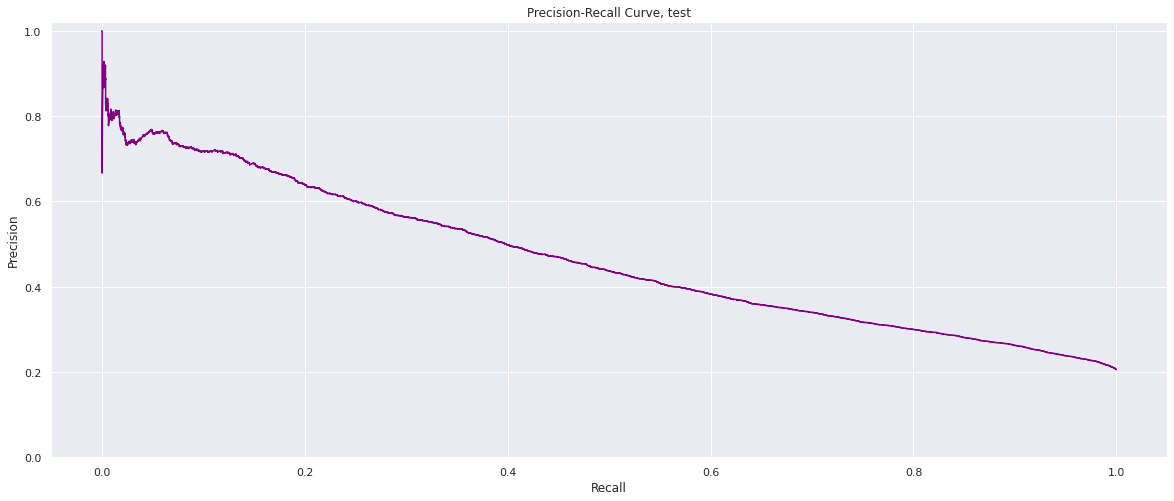

In [59]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

In [60]:
X_train.columns

Index(['verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'initial_list_status_w', 'application_type_Joint App', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment',
       'fico_range_high', 'emp_length', 'annual_inc', 'dti', 'mo_sin_rcnt_tl',
       'mths_since_last_delinq', 'mths_since_last_major_derog',
       'mths_since_last_record', 'mths_since_recent_bc_dlq',
       'mths_since_recent_revol_delinq', 'num_tl_op_past_12m',
       'inq_last_6mths', 'inq_fi', 'inq_last_12m', 'open_acc',
       'acc_open_past_24mths', 'mort_acc', 'total_acc', 'avg_cur_bal',
       'tot_cur_bal', 'revol_bal', 'revol_util', 'bc_open_to_buy',
       'mo_sin_rcnt_rev_tl_op', 'num_actv_rev_tl', 'num_op_rev_tl',
       'total_rev_hi_lim', 'delinq_2yrs', 'acc_now_delinq', 'delinq_amnt',
       'pub_rec', 'pub_rec_bankruptcies', 'total_bal_ex_mort', 'tot_coll_amt',
       'tax_liens', 'percent_bc_gt_75'

In [ ]:
### Fit XGBoost using Optuna hyperparameter optimization ###

time1 = time.time()

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=2):

    cv_regularizer=0.01
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.005, 0.25),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict_proba(X_B)[:, 1]
            #y_pred_train[train_index] += model.predict_proba(X_A)[:, 1]
                      
        #precision_t, recall_t, threshold = precision_recall_curve(y_train, y_pred_train)
        #score_train = auc(recall_t, precision_t)
        precision_t, recall_t, threshold = precision_recall_curve(y_train, y_pred)
        score_test = auc(recall_t, precision_t)
            
        #score_train = roc_auc_score(y_train, y_pred_train)
        #score_test = roc_auc_score(y_train, y_pred) 
        #overfit = score_train-score_test
        #temp_out.append(score_test-cv_regularizer*overfit)
        temp_out.append(score_test)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, train')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

[I 2022-08-13 22:47:03,634] A new study created in memory with name: no-name-6d151519-f691-4e59-9014-3d9785adff6e
[I 2022-08-13 22:47:17,873] Trial 0 finished with value: 0.44827012670670374 and parameters: {'n_estimators': 1191, 'max_depth': 5, 'learning_rate': 0.10280911236222993, 'colsample_bytree': 0.5989192188901953, 'subsample': 0.8445767305704425, 'alpha': 0.12772810247807181, 'lambda': 0.5925225727030465, 'gamma': 0.0013107352226054175, 'min_child_weight': 0.10772784531330644}. Best is trial 0 with value: 0.44827012670670374.
[I 2022-08-13 22:47:24,649] Trial 1 finished with value: 0.4655678916205214 and parameters: {'n_estimators': 1056, 'max_depth': 2, 'learning_rate': 0.18784773845140218, 'colsample_bytree': 0.38346708255453266, 'subsample': 0.503714848039393, 'alpha': 0.5468112923810898, 'lambda': 0.42462947526294387, 'gamma': 1.4881096862915512e-10, 'min_child_weight': 0.12697844848468248}. Best is trial 1 with value: 0.4655678916205214.
[I 2022-08-13 22:47:54,446] Trial 2

### 7. Model interpretation

In [ ]:
#results_fi = permutation_importance(optuna_xgb, X_test, y_test, n_jobs=-1)
#fi = pd.DataFrame({'col':X_test.columns, 'FI':results_fi.importances_mean})
#fi = fi.sort_values('FI', ascending = False)

#display(fi)

In [ ]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
#display(feature_importance)

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)
shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)

In [ ]:
# error analysis
y_pred = optuna_xgb.predict_proba(X_test)[:, 1]
error_df = test00.copy()
error_df['truth'] = y_test
error_df['pred'] = y_pred
error_df['error'] = error_df.pred - error_df.truth
error_df

In [ ]:
display(error_df[['truth', 'pred']].describe(),error_df[error_df.error>0.8])

In [ ]:
error_df.describe()

In [ ]:
display(error_df[['truth', 'pred']].describe(),error_df[error_df.error<-0.95])

In [ ]:
#indx = 1
#fig = plt.subplots(figsize=(6,6),dpi=200)
#ax_2= shap.decision_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[indx],link= "logit")

#shap.initjs()
#shap.force_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[[indx]],link= "logit")

In [ ]:
error_df[['pred','truth']].describe()

In [ ]:
display(error_df.groupby('year_issued').error.mean())
display(error_df.groupby('term').error.mean())
display(error_df.groupby('grade').error.mean())
display(error_df.groupby('purpose').error.mean())

In [ ]:
time.time()-time0

### 8. Business implications

#### 8.1 Is this model useful?

This project is a perfect illustration of how machine learning can create value if we think hard about business problem at hand rather than focusing on a few narrow model evaluation metrics.

If you view this project as a purely data mining and prediction problem, then it is arguably a failure. Model accuracy is 81% which barely beats 80% from a trivial model, always predicting no default. F1 score is only 36%, which is not impressive.

However, the predictive model above can create value if used properly. Let me show how.

Precision-recall curve above shows that model is actually very good in predicting defaults for around one quarter of defaulted loans. For example, its precision at 20% recall is _ %. This means that if we use the model only to predict default for those loans it is most confident about, we can avoid at least 20% of credit losses while forgoing relatively few profitable lending opportunities. 

#### 8.2 How much value does it create?

While trying to quantify value created by the model, I will make a few assumptions about Lending Club business structure. They will be imperfect. The purpose of this section is to get back of the envelope approximation of the increase in operational profit of Lending Club from using the model rather tthen build financial model of Lending Club.

